## Beispiel ebix Datei auswerten

Lese ebix Datei

In [18]:
import xml.etree.ElementTree as et
from datetime import datetime, timedelta
import pandas as pd

ns = {'rsm': 'http://www.strom.ch'}

xtree = et.parse("./Testdateien/ValidatedMeterData.xml")
elements = xtree.getroot()

sender = elements.find('.//rsm:Sender/rsm:ID/rsm:EICID', ns).text


report_period_start = elements.find('.//rsm:ReportPeriod/rsm:StartDateTime', ns).text
report_period_end = elements.find('.//rsm:ReportPeriod/rsm:EndDateTime', ns).text
# Get information about report period
dt_start = datetime.strptime(report_period_start, '%Y-%m-%dT%H:%M:%S%z')
dt_end = datetime.strptime(report_period_end, '%Y-%m-%dT%H:%M:%S%z')
report_period_diff = dt_end - dt_start
report_period = {
    'start': dt_start,
    'end': dt_end,
    'diff': report_period_diff
}

# Get metering data
meteringcodes = []
values = []
labels = []

for mc in elements.findall('.//rsm:MeteringData', ns):
    label = ['x', ]
    start = mc.find('rsm:Interval/rsm:StartDateTime', ns).text
    dt_start = datetime.strptime(start, '%Y-%m-%dT%H:%M:%SZ')
    end = mc.find('rsm:Interval/rsm:EndDateTime', ns).text
    dt_end = datetime.strptime(end, '%Y-%m-%dT%H:%M:%SZ')
    product = mc.find('rsm:Product/rsm:ID', ns).text
    product_unit = mc.find('rsm:Product/rsm:MeasureUnit', ns).text
    resolution = mc.find('rsm:Resolution/rsm:Resolution', ns).text
    resoltion_unit = mc.find('rsm:Resolution/rsm:Unit', ns).text

    if mc.find('rsm:ExchangeMeteringPoint/rsm:VSENationalID', ns) != None:
        mc_id = mc.find('rsm:ExchangeMeteringPoint/rsm:VSENationalID', ns).text
        value = [mc.find('rsm:ExchangeMeteringPoint/rsm:VSENationalID', ns).text, ]
        dt_start = dt_start + timedelta(hours=2)
        tmp_start = dt_start
        for val in mc.findall('rsm:Observation/rsm:Volume', ns):
            value.append(val.text)
        # Analyse with pandas
        periods = len(mc.findall('rsm:Observation/rsm:Volume', ns))
        rng = pd.date_range(dt_start, periods=periods, freq='15Min')
        df2 = pd.Series(data=value[1:], index=rng, dtype=float)
        # if periods > 2976:
        #     df2 = df2.resample('1d').sum()
        # else:
        #     df2 = df2.resample('1H').sum()
        # df2 = df2.astype(int)
        result = []
        for index, values in df2.items():
            result.append({
                'x': index.strftime("%Y-%m-%dT%H:%M:%S"),
                'y': values
            })

        in_area = mc.find('rsm:ExchangeMeteringPoint/rsm:Direction/rsm:InArea/rsm:EICID', ns).text
        out_area = mc.find('rsm:ExchangeMeteringPoint/rsm:Direction/rsm:OutArea/rsm:EICID', ns).text
        meteringcode = {
            'meteringcode': mc_id,
            'product': product,
            'resolution': resolution,
            'resolution_unit': resoltion_unit,
            'product_unit': product_unit,
            'start': tmp_start,
            'end': dt_end + timedelta(hours=2),
            'exchange_mp': True,
            'in_area': in_area,
            'out_area': out_area,
            'values': df2,
        }
        meteringcodes.append(meteringcode)
    elif mc.find('rsm:ConsumptionMeteringPoint/rsm:VSENationalID', ns) != None:
        mc_id = mc.find('rsm:ConsumptionMeteringPoint/rsm:VSENationalID', ns).text
        value = [mc_id, ]
        dt_start = dt_start + timedelta(hours=2)
        tmp_start = dt_start
        for val in mc.findall('rsm:Observation/rsm:Volume', ns):
            value.append(val.text)
        # Analyse with pandas
        periods = len(mc.findall('rsm:Observation/rsm:Volume', ns))
        rng = pd.date_range(dt_start, periods=periods, freq='15Min')
        df2 = pd.Series(data=value[1:], index=rng, dtype=float)
        # if periods > 2976:
        #     df2 = df2.resample('1d').sum()
        # else:
        #     df2 = df2.resample('1H').sum()
        df2 = df2.astype(int)
        result = []
        for index, values in df2.items():
            result.append({
                'x': index.strftime("%Y-%m-%dT%H:%M:%S"),
                'y': values
            })
        meteringcode = {
            'meteringcode': mc_id,
            'product': 'Consumption',
            'resolution': resolution,
            'resolution_unit': resoltion_unit,
            'product_unit': product_unit,
            'start': tmp_start,
            'end': dt_end + timedelta(hours=2),
            'exchange_mp': False,
            'in_area': '',
            'out_area': '',
            'values': result,
        }
        meteringcodes.append(meteringcode)
    else:
        mc_id = mc.find('rsm:ProductionMeteringPoint/rsm:VSENationalID', ns).text
        value = [mc_id, ]
        tmp_start = dt_start
        for val in mc.findall('rsm:Observation/rsm:Volume', ns):
            value.append(val.text)
        # Analyse with pandas
        periods = len(mc.findall('rsm:Observation/rsm:Volume', ns))
        rng = pd.date_range(dt_start, periods=periods, freq='15Min')
        df2 = pd.Series(data=value[1:], index=rng, dtype=float)
        # if periods > 2976:
        #     df2 = df2.resample('1d').sum()
        # else:
        #     df2 = df2.resample('1H').sum()
        # df2 = df2.astype(int)
        df2.resample('1d').sum().plot.bar()
        result = []
        for index, values in df2.items():
            result.append({
                'x': index.strftime("%Y-%m-%dT%H:%M:%S"),
                'y': values
            })
        meteringcode = {
            'meteringcode': mc_id,
            'product': 'Production',
            'resolution': resolution,
            'resolution_unit': resoltion_unit,
            'product_unit': product_unit,
            'start': tmp_start,
            'end': dt_end,
            'exchange_mp': False,
            'in_area': '',
            'out_area': '',
            'values': df2
        }

        meteringcodes.append(meteringcode)

data = {
    'sender': sender,
    'report_period': report_period
}
meterdata = {
    'meteringcodes': meteringcodes,
    'values': values,
    'labels': label
}



## Forecast
[Docs](https://facebook.github.io/prophet/)

In [20]:
# Data cleaning
from fbprophet import Prophet

dfx = meterdata.get('meteringcodes')[0].get('values')
# dfx.resample('1d').sum().plot.line()
dfx.head()

2020-07-01 00:00:00     7.550
2020-07-01 00:15:00     5.650
2020-07-01 00:30:00     3.725
2020-07-01 00:45:00     4.550
2020-07-01 01:00:00    11.000
Freq: 15T, dtype: float64

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [21]:
# Prepare Dataframe
dfxc = dfx.copy()
dfxc = dfxc.resample('1h').sum()
dataframe = dfxc.to_frame(name='y')
dataframe['ds']=dataframe.index
dataframe.reset_index(inplace=True)
dataframe.drop(['index'], axis=1, inplace=True)
dataframe = dataframe[['ds', 'y']]
dataframe.head()


,ds,y
0,2020-07-01 00:00:00,21.475
1,2020-07-01 01:00:00,50.500
2,2020-07-01 02:00:00,33.875
3,2020-07-01 03:00:00,41.025
4,2020-07-01 04:00:00,25.075


NameError: name 'plt' is not defined

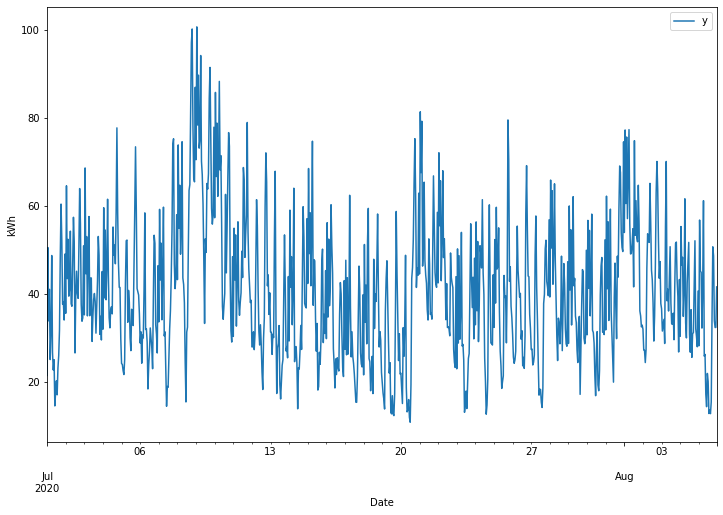

In [22]:
ax = dataframe.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('kWh')
ax.set_xlabel('Date')

plt.show()

In [31]:
# Forecast
model = Prophet(yearly_seasonality=False)
model.fit(dataframe)
future = model.make_future_dataframe(30)
forecast = model.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
889,2020-08-31 23:00:00,50.306428,22.519246,74.121094,31.224878,69.865117,-2.103570,-2.103570,-2.103570,-1.393483,-1.393483,-1.393483,-0.710087,-0.710087,-0.710087,0.0,0.0,0.0,48.202858
890,2020-09-01 23:00:00,50.622341,24.526688,74.863622,30.386701,71.009959,-1.196912,-1.196912,-1.196912,-1.393483,-1.393483,-1.393483,0.196571,0.196571,0.196571,0.0,0.0,0.0,49.425430
891,2020-09-02 23:00:00,50.938254,25.142882,77.709235,29.435974,72.295480,-0.105715,-0.105715,-0.105715,-1.393483,-1.393483,-1.393483,1.287768,1.287768,1.287768,0.0,0.0,0.0,50.832540
892,2020-09-03 23:00:00,51.254167,23.403875,79.466013,28.615002,73.905833,1.191684,1.191684,1.191684,-1.393483,-1.393483,-1.393483,2.585167,2.585167,2.585167,0.0,0.0,0.0,52.445851
893,2020-09-04 23:00:00,51.570080,22.836106,81.463786,28.029495,75.639414,1.146760,1.146760,1.146760,-1.393483,-1.393483,-1.393483,2.540243,2.540243,2.540243,0.0,0.0,0.0,52.716840


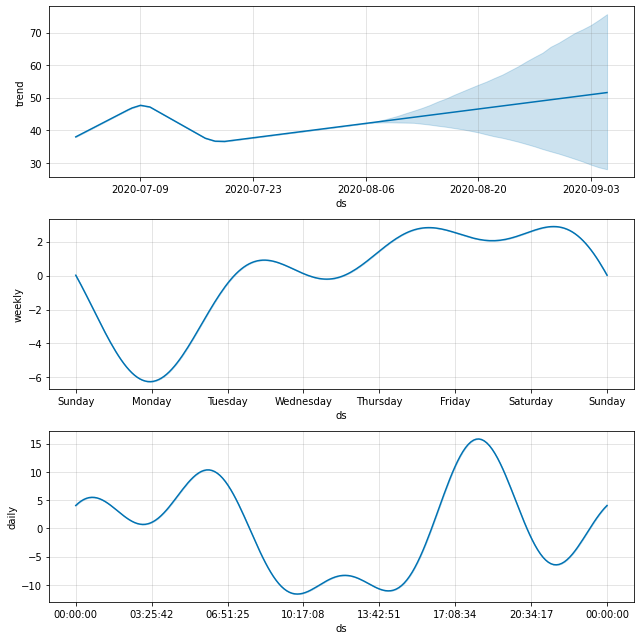

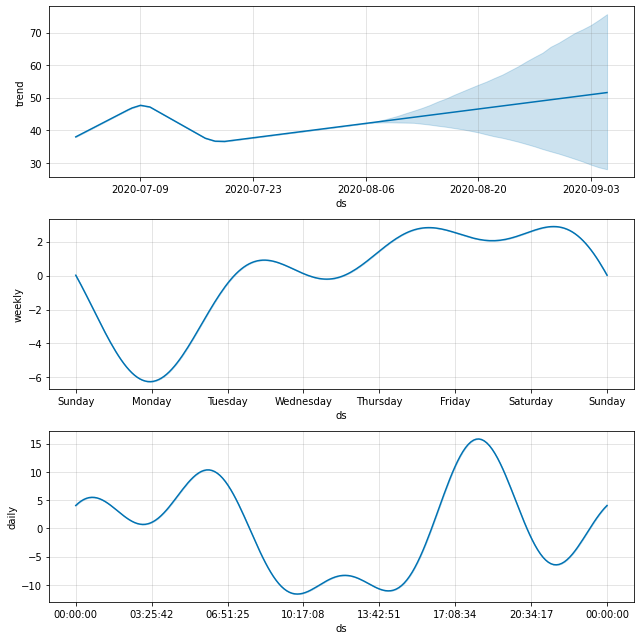

In [32]:
model.plot_components(forecast)

In [33]:
from fbprophet.plot import plot_plotly, plot_components_plotly

plot_components_plotly(model, forecast)

In [34]:
plot_plotly(model, forecast)